# Natural Language Processing

In this homework assignment, you will tackle three distinct tasks involving text analysis:

1. Tweet Classification: Predict whether a specific tweet pertains to a natural disaster.
2. Bank Q&A Analysis: Deduce the user's query based on the text provided.
3. Fake News Classification: Determine whether a piece of news is true or false.

For educational reasons, we have retained all utility cells for data downloads. However, you can find everything you need in the corresponding GitHub repository subfolder.

# Solution Approach

Our solution approach will remain relatively consistent for all tasks:

1. Encode the text using a certain Language Model (LM), transforming each piece of text into a vector.
2. Implement a standard classification model (such as Logistic Regression, Random Forest, etc.) using these features.

Despite the varied nature of these tasks, you'll find that this approach provides a solid baseline solution for all three.

In [152]:
# !pip install kaggle

In [153]:
# !kaggle competitions download -c nlp-getting-started

In [154]:
# !unzip nlp-getting-started.zip

# Task 1. Tweets

https://www.kaggle.com/competitions/nlp-getting-started


1. What is this dataset about?
    - To identify and classify the most popular words used in tweets.
    - To determine the sentiment of tweets on a large scale.
    - To develop a machine learning model that can distinguish between tweets about real disasters and those that are not.
    - To track the user activity on Twitter during emergency situations.
2. Encode text with LM, what is the dimensionality of the resulting embeddings?
    - 7613
    - 128
    - 768
    - 512
    - it varies depending on input sequence from 128 to 1024
3. Plot TSNE describe the graph (run TSNE on 128 PCA components).
    - upload pdf
4. Run LR, use 5 fold cross-validation, which metrics are appropriate for this task?
    - ROC AUC 
    - accuracy score
    - Mean Squared Error
    - F1 score
    - Precision and Recall
5. Comment on model performance
6. Explore the results (use out-of-fold predictions), find 3 False Positive tweets, which do not really look like a disaster, e.g.:
- https://twitter.com/shauniefish/status/649148030290006017 `I just checked in! \x89ÛÒ at On Fire on @ZomatoAUS #LoveFood http://t.co/9l5kqykrbG`
    - upload pdf, what is your model's performance, comment on how to use your model for public alert notifications, based on viral tweets activity

In [17]:
import pandas as pd

In [20]:
df = pd.read_csv('train.csv', index_col=0)

In [172]:
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [179]:
df['has_hastag'] = df.text.apply(lambda x: '#' in x)

In [180]:
df.groupby('target')['has_hastag'].mean()

target
0    0.204053
1    0.267502
Name: has_hastag, dtype: float64

In [173]:
df.shape

(7613, 4)

In [186]:
df.query('target==1').keyword.value_counts()[:20]

keyword
derailment               39
wreckage                 39
outbreak                 39
debris                   37
oil%20spill              37
typhoon                  37
evacuated                32
suicide%20bombing        32
rescuers                 32
suicide%20bomb           32
nuclear%20disaster       31
razed                    31
suicide%20bomber         30
earthquake               30
airplane%20accident      30
collision                29
wildfire                 29
bridge%20collapse        29
evacuation               28
buildings%20on%20fire    28
Name: count, dtype: int64

In [187]:
df.query('target==0').keyword.value_counts()[:20]

keyword
body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
aftershock     34
panic          34
screaming      34
blizzard       33
blazing        33
blaze          33
crush          33
sinking        33
traumatised    33
curfew         32
Name: count, dtype: int64

In [158]:
df.keyword.value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [166]:
df.keyword.value_counts().sum()

7552

In [175]:
df.location.count()

5080

In [176]:
df.location.value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [135]:
# !pip install langchain

In [134]:
# !pip install sentence-transformers

In [26]:
from langchain.embeddings import HuggingFaceEmbeddings
from tqdm.notebook import tqdm

In [2]:
embeddings = HuggingFaceEmbeddings()

In [4]:
len(embeddings.embed_query('Hello, World!'))

768

In [37]:
embeddings = HuggingFaceEmbeddings()
tweet_embeddings = []

for _, tweet in tqdm(df.iterrows()):
    vec = embeddings.embed_query(tweet.text)
    tweet_embeddings.append(vec)

0it [00:00, ?it/s]

In [39]:
len(tweet_embeddings)

7613

In [94]:
import numpy as np
from openTSNE import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
pca = PCA(128)
X_pca = pca.fit_transform(tweet_embeddings)
tsne_embedding = TSNE().fit(np.array(X_pca))

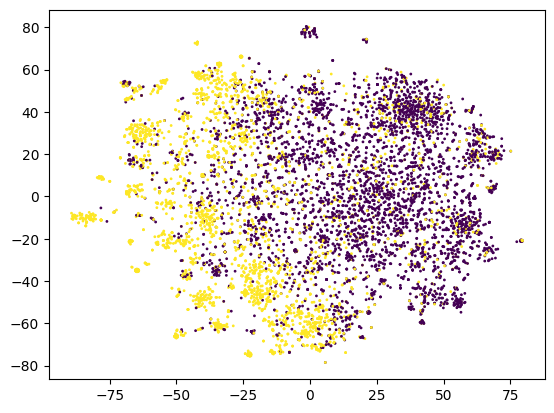

In [101]:
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=df.target, s=1);

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score

In [72]:
clf = LogisticRegression()
y_pred = cross_val_predict(clf, tweet_embeddings, y=df.target, method='predict_proba')

In [73]:
y_pred.shape

(7613, 2)

In [71]:
roc_auc_score(df.target, y_pred[:, 1])

0.8695270372173367

In [189]:
clf = LogisticRegression()
y_pred = cross_val_predict(clf, tweet_embeddings, y=df.target, method='predict')

In [211]:
df.iloc[3770].text

'I just checked in! \x89ÛÒ at On Fire on @ZomatoAUS #LoveFood http://t.co/9l5kqykrbG'

In [201]:
for i,(a,b) in enumerate(zip(df.target, y_pred)):
    if a!=b:
        print(i, a, b)

31 1 0
35 0 1
71 0 1
73 1 0
81 1 0
99 1 0
101 0 1
138 0 1
150 0 1
166 0 1
167 0 1
171 1 0
180 1 0
194 0 1
195 1 0
200 0 1
205 0 1
214 1 0
224 1 0
225 1 0
229 1 0
234 1 0
243 1 0
247 1 0
249 1 0
251 1 0
253 1 0
256 1 0
264 1 0
269 1 0
271 1 0
273 1 0
281 1 0
290 1 0
292 0 1
299 1 0
300 1 0
301 1 0
317 1 0
321 1 0
331 1 0
342 1 0
354 1 0
356 1 0
358 1 0
361 1 0
374 0 1
380 0 1
383 0 1
384 1 0
388 0 1
396 1 0
397 0 1
407 1 0
412 1 0
418 0 1
420 0 1
421 0 1
423 0 1
425 0 1
430 0 1
444 0 1
446 1 0
448 1 0
461 1 0
466 1 0
467 1 0
468 1 0
472 1 0
502 1 0
533 1 0
535 1 0
544 1 0
545 1 0
546 0 1
547 1 0
548 1 0
552 1 0
556 1 0
571 0 1
574 0 1
575 0 1
578 0 1
582 0 1
583 0 1
584 0 1
589 0 1
590 1 0
591 0 1
594 0 1
595 0 1
597 0 1
600 0 1
606 0 1
609 0 1
613 0 1
614 1 0
620 1 0
624 0 1
627 0 1
632 1 0
633 1 0
634 0 1
635 1 0
649 1 0
680 1 0
696 0 1
697 0 1
699 0 1
719 1 0
728 1 0
733 1 0
735 1 0
748 0 1
753 1 0
759 0 1
760 0 1
770 0 1
788 0 1
789 1 0
795 0 1
809 0 1
819 1 0
821 1 0
836 1 0
842 1 

In [163]:
embeddings = HuggingFaceEmbeddings()
tweet_embeddings = []
keyword_embeddings = []

for _, tweet in tqdm(df.iterrows()):
    keyword_embeddings.append(embeddings.embed_query(str(tweet.keyword)))
    vec = embeddings.embed_query(tweet.text)
    tweet_embeddings.append(vec)

0it [00:00, ?it/s]

In [170]:
clf = LogisticRegression()
y_pred = cross_val_predict(clf, np.array(tweet_embeddings), y=df.target, method='predict_proba')

In [171]:
roc_auc_score(df.target, y_pred[:, 1])

0.8689395777501743

In [43]:
df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [50]:
df.target.unique()

array([1, 0])

In [51]:
y_pred

array([0.55042832, 1.12211154, 0.73745754, ..., 0.88315442, 0.76225094,
       0.97559488])

# Task 2. Bank Customers' Q&A system

https://huggingface.co/datasets/PolyAI/banking77


1. What is this dataset about?
    - To train a model to predict the popularity of banking services.
    - To facilitate the development of models for intent detection in the banking domain.
    - To create a model for detecting fraudulent activities in banking transactions.
    - To develop a system for sentiment analysis of banking customer queries.
2. What is the minimal and maximal median text length for different classes (e.g. median text length for `atm_support` is 35).
    - min 30, max 66
    - min 32, max 91
3. Encode text with LM
4. Run RF, use 5 fold cross-validation, which metrics are appropriate for this task?

    - ROC AUC
    - accuracy score
    - Mean Squared Error
    - F1 score (1 vs all)
    - Precision and Recall (1 vs all)

5. Comment on model performance, how many classes are in your dataset?
    - 2
    - 77
    - 22
    - 10003
    - 7

6. Analyze the errors of your model (use out-of-fold predictions), which two classes are mostly confused by your model?
     - balance_not_updated_after_bank_transfer AND transfer_timing
     - card_arrival AND lost_or_stolen_phone
     - card_arrival AND pin_blocked
     - exchange_rate AND receiving_money
7. (optional) plot a TSNE graph, with all observations, but color only two classes from the previous question. Make other points  color ligth gray, comment on the graph.

In [6]:
import pandas as pd

In [14]:
df2 = pd.read_csv('https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv')

In [17]:
embeddings = HuggingFaceEmbeddings()
messages_embeddings = []

for _, message in tqdm(df2.iterrows()):
    vec = embeddings.embed_query(message.text)
    messages_embeddings.append(vec)

0it [00:00, ?it/s]

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf = RandomForestClassifier(10)
y_pred = cross_val_predict(clf, messages_embeddings, y=df2.category, method='predict')

NameError: name 'cross_val_predict' is not defined

In [ ]:
df2['len'] = df2.text.apply(lambda x: len(x))

In [ ]:
df2.groupby('category').len.mean().sort_values()

In [ ]:
errors = dict()

for i,(a,b) in enumerate(zip(df2.category, y_pred)):
    if a!=b:
        key = '-'.join(sorted([a,b]))
        if key in errors:
            errors[key] += 1
        else:
            errors[key] = 1
#         print(a)
#         print(b)
#         print(df2.iloc[i].text)
#         print('======')

In [261]:
sorted(errors.items(), key=lambda x: x[1])

[('card_arrival-lost_or_stolen_phone', 1),
 ('card_arrival-terminate_account', 1),
 ('Refund_not_showing_up-card_arrival', 1),
 ('card_arrival-topping_up_by_card', 1),
 ('cancel_transfer-card_arrival', 1),
 ('balance_not_updated_after_cheque_or_cash_deposit-card_arrival', 1),
 ('card_acceptance-card_linking', 1),
 ('card_linking-cash_withdrawal_not_recognised', 1),
 ('exchange_rate-receiving_money', 1),
 ('exchange_rate-pending_top_up', 1),
 ('balance_not_updated_after_bank_transfer-exchange_rate', 1),
 ('automatic_top_up-exchange_rate', 1),
 ('exchange_rate-supported_cards_and_currencies', 1),
 ('card_payment_wrong_exchange_rate-direct_debit_payment_not_recognised', 1),
 ('card_payment_wrong_exchange_rate-exchange_charge', 1),
 ('apple_pay_or_google_pay-card_payment_wrong_exchange_rate', 1),
 ('age_limit-card_payment_wrong_exchange_rate', 1),
 ('card_payment_wrong_exchange_rate-top_up_by_card_charge', 1),
 ('card_payment_fee_charged-card_payment_wrong_exchange_rate', 1),
 ('beneficiar

In [217]:
accuracy_score(df2.category, y_pred, )

0.8034589623113066

In [218]:
from sklearn.metrics import confusion_matrix

In [223]:
cm = confusion_matrix(df2.category, y_pred)

In [231]:
cm[0, :].sum()

162

In [232]:
np.fill_diagonal(cm, 0)

In [257]:
np.sort(cm.reshape(-1))

array([ 0,  0,  0, ..., 20, 21, 21])

In [235]:
cm.shape

(77, 77)

In [238]:
2780%77

8

In [239]:
cm[36, 8]

21

In [240]:
np.max(cm)

21

In [241]:
np.unique(y_pred)[36]

'failed_transfer'

In [242]:
np.unique(y_pred)[8]

'beneficiary_not_allowed'

In [109]:
df2.category.value_counts()

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: count, Length: 77, dtype: int64

# Task 3. Fake news

https://www.kaggle.com/datasets/jainpooja/fake-news-detection

1. What is this dataset about?
2. How many unique subjects are in True news and Fake news?
    - 2, 6
    - 23481, 21417
    - 9050, 10145
    - 2, 2
3. Encode text with LM
4. Run LR, use 5 fold cross-validation, which metrics are appropriate for this task?
5. Comment on model performance,  would you prefer a model with high Recall or with high Precision? explain
6. Analyze class distribution of the model. How many articles mentioning "Trump" are Fake? How many articles not mentioning "Trump" are Fake? 
    - two number divided by a comma
7. Same question for "Obama". Can you say that this dataset is biased, explain?
    - two number divided by a comma
8. (optional) using your model find False Positives which are actually True statements (news).


In [288]:
# !kaggle datasets download -d jainpooja/fake-news-detection

In [289]:
# !unzip fake-news-detection.zip

In [21]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
data			 home_assignment_4_solution.ipynb
home_assignment_4.ipynb  news_embeddings.npy


In [22]:
df3 = pd.read_csv('./data/fake_news/Fake.csv')

In [23]:
df3.shape

(23481, 4)

In [125]:
df3.subject.value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

In [24]:
df4 = pd.read_csv('./data/fake_news/True.csv')

In [25]:
df4.shape

(21417, 4)

In [127]:
df4.subject.value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [130]:
df3.shape

(23481, 4)

In [131]:
df4.shape

(21417, 4)

In [128]:
df5 = pd.concat([df3, df4])

In [132]:
df5['is_fake'] = [1]*23481+[0]*21417

In [133]:
embeddings = HuggingFaceEmbeddings()
news_embeddings = []

for _, message in tqdm(df5.iterrows()):
    vec = embeddings.embed_query(message.text)
    news_embeddings.append(vec)

0it [00:00, ?it/s]

In [262]:
len(news_embeddings)

44898

In [155]:
np.save('news_embeddings.npy', news_embeddings)

In [136]:
clf = LogisticRegression()
y_pred = cross_val_predict(clf, news_embeddings, y=df5.is_fake, method='predict_proba')

In [139]:
roc_auc_score(df5.is_fake, y_pred[:,1])

0.9906792271065874

In [263]:
clf = LogisticRegression()
y_pred = cross_val_predict(clf, news_embeddings, y=df5.is_fake, method='predict')

In [264]:
accuracy_score(df5.is_fake, y_pred)

0.9535836785602922

In [269]:
confusion_matrix(df5.is_fake, y_pred)

array([[20429,   988],
       [ 1096, 22385]])

In [273]:
errors = dict()

for i,(a,b) in enumerate(zip(df5.is_fake, y_pred)):
    if a==1 and b==0:
#         key = '-'.join(sorted([a,b]))
#         if key in errors:
#             errors[key] += 1
#         else:
#             errors[key] = 1
        print(a)
        print(b)
        print(df5.iloc[i].text[:500])
        print('======')
        

1
0
Republicans have had seven years to come up with a viable replacement for Obamacare but they failed miserably. After taking a victory lap for gifting the wealthy with a tax break on Wednesday, Donald Trump looked at the cameras and said,  We have essentially repealed Obamacare and we will come up with something that will be much better. Obamacare has been repealed in this bill,  he added. Well, like most things Trump says, that s just not true. But, if the former reality show star could have don
1
0
New questions are being asked about President Donald Trump s ability to lead after he slurred his words during a speech about his Jerusalem decision. Possible reasons for this include: fatigue, a dry mouth (the White House explanation), the use of drugs or alcohol, a problem with his dentures or more troubling issues dealing with his mental or physical health. Morning Joe reported this morning that, unlike other presidents, Trump has opted not to get his physicals at the Walter Reed Arm

In [141]:
tsne_embedding = TSNE().fit(np.array(news_embeddings[::10]))

In [283]:
df5['is_obama'] = df5['text'].apply(lambda x: 'Obama' in x)
df5['is_biden'] = df5['text'].apply(lambda x: 'Biden' in x)

In [279]:
df5.is_obama.value_counts()

is_obama
False    34226
True     10672
Name: count, dtype: int64

In [284]:
df5.is_biden.value_counts()

is_biden
False    44517
True       381
Name: count, dtype: int64

In [286]:
df5.groupby('is_obama').is_fake.agg(['mean', 'std'])

,mean,std
is_obama,,
False,0.495296,0.499985
True,0.611788,0.487366


In [287]:
df5.groupby('is_trump').is_fake.agg(['mean', 'std'])

,mean,std
is_trump,,
False,0.480302,0.499623
True,0.566805,0.495528


In [285]:
df5.groupby('is_biden').is_fake.mean()

is_biden
False    0.521576
True     0.687664
Name: is_fake, dtype: float64

In [149]:
df5.subject[::10].map(dict(zip(['politicsNews', 'worldnews', 'News', 'politics', 'left-news',
       'Government News', 'US_News', 'Middle-east'], range(8))))

0        2
10       2
20       2
30       2
40       2
        ..
21369    1
21379    1
21389    1
21399    1
21409    1
Name: subject, Length: 4490, dtype: int64

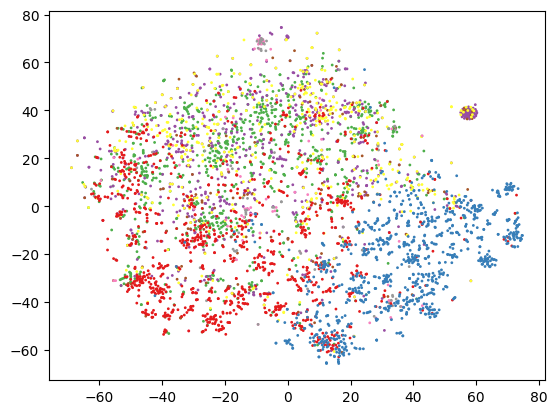

In [151]:
color_subject = df5.subject[::10].map(dict(zip(['politicsNews', 'worldnews', 'News', 'politics', 'left-news',
       'Government News', 'US_News', 'Middle-east'], range(8))))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=color_subject, s=1, cmap='Set1');